# Multi-Class Classification on "Operating Systems" Category

## 1. Imports

In [1]:
import ast
import random
import re
import string
from collections import Counter
from pathlib import Path
from typing import Union, Any

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from wordcloud import WordCloud

from preprocess_functions import build_tree, extract_keys, map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance, tokenizer_transform, \
    replace_text_components, clean_text, lemmatize_text, remove_stopwords

2025-02-05 13:34:03.551340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/cela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cela/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/cela/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cela/nltk_data...
[nltk_data]   Pack

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = True
RETRAIN = True
RANDOM_STATE = 42
MODEL_LEVEL = 'operating_systems'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'mac os': 'mac os',
    'windows': 'windows',
    'unix': 'unix',
    'linux': 'linux'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    #'gaussian_nb': GaussianNB(),
    #'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_train.csv'

OPERATING_SYSTEMS_PKL = MODELS_DIR / f'{MODEL_LEVEL}.pkl'
BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'

LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'

CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest for the category 'computer security' are:
1. mac os
2. windows
3. unix
4. linux

In [10]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)
threat_tweets['text'] = [replace_text_components(t) for t in threat_tweets['text']]
threat_tweets['text'] = [clean_text(t) for t in threat_tweets['text']]
threat_tweets['text'] = [lemmatize_text(t) for t in threat_tweets['text']]
threat_tweets['text'] = [remove_stopwords(t) for t in threat_tweets['text']]

threat_tweets = threat_tweets[
    threat_tweets["watson_list"].apply(lambda x: ' '.join(MODEL_LEVEL.split(sep='_')) in x)
].reset_index(drop=True)

print(f"Threat Tweets: {len(threat_tweets)}")
threat_tweets.head()

Threat Tweets: 839


,text,watson,watson_list,target
0,cve20180648 untrusted search path vulnerabilit...,{'technology and computing': {'operating syste...,"[technology and computing, operating systems, ...","[linux, windows]"
1,cve20181000663 jsish version 2470 2047 contain...,{'technology and computing': {'operating syste...,"[technology and computing, operating systems, ...",[linux]
2,microsoft expedite fix unauthenticated rce dco...,"{'technology and computing': {'software': {}, ...","[technology and computing, software, operating...",[windows]
3,new post socusoft 3gp photo slideshow 805 buff...,"{'technology and computing': {'software': {}, ...","[technology and computing, software, operating...",[linux]
4,trend micro apps leak user data remove mac app...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[mac os]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [11]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('vulnerability', 370), ('overflow', 202), ('buffer', 197), ('window', 139), ('microsoft', 83), ('service', 83), ('denial', 77), ('version', 73), ('local', 72), ('disclosure', 60)]


#### 4.1.2. Word Cloud

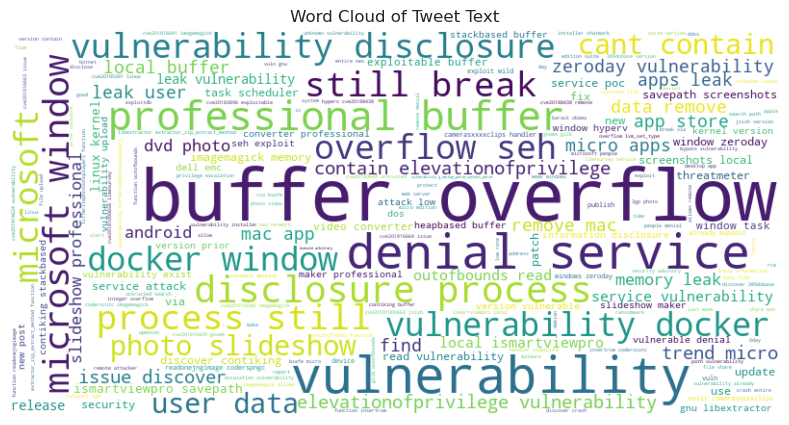

In [12]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

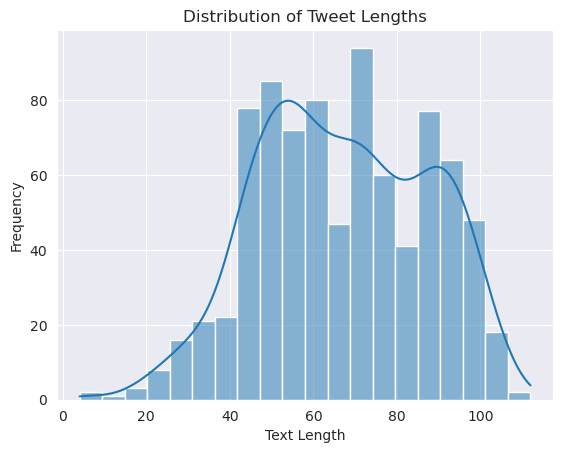

In [13]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [14]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 839), ('operating systems', 839), ('software', 501), ('linux', 392), ('computer security', 289), ('windows', 228), ('antivirus and malware', 198), ('databases', 164), ('hardware', 142), ('unix', 133)]


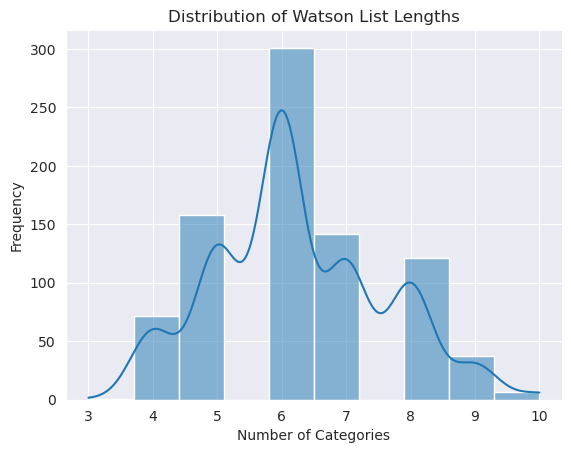

In [15]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [16]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'operating systems'), 839), (('technology and computing', 'software'), 501), (('technology and computing', 'linux'), 392), (('operating systems', 'linux'), 392), (('operating systems', 'software'), 335), (('technology and computing', 'computer security'), 289), (('technology and computing', 'windows'), 228), (('operating systems', 'windows'), 228), (('technology and computing', 'antivirus and malware'), 198), (('computer security', 'antivirus and malware'), 198)]


In [17]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 839), ('operating', 839), ('software', 501), ('computer', 436), ('linux', 392), ('windows', 228), ('antivirus', 198), ('databases', 164), ('hardware', 142), ('unix', 133), ('network', 115), ('mac', 87), ('consumer', 66), ('home', 58), ('programming', 47), ('sports', 35), ('telephones', 34), ('mobile', 34), ('smart', 34), ('business', 31), ('health', 31), ('tv', 29), ('video', 28), ('dvd', 28), ('plumbing', 26), ('art', 24), ('c', 23), ('disease', 22), ('shareware', 20), ('law,', 18), ('skiing', 18), ('finance', 18), ('society', 15), ('music', 14), ('bank', 14), ('java', 13), ('science', 13), ('portable', 12), ('javascript', 12), ('movies', 10), ('networking', 10), ('servers', 9), ('vpn', 9), ('food', 9), ('router', 8), ('internet', 8), ('hobbies', 7), ('running', 7), ('laptop', 7), ('skating', 7), ('crime', 7), ('accounting', 7), ('travel', 7), ('legal', 7), ('personal', 7), ('opera', 6), ('automotive', 6), ('graphics', 6), ('enterprise',

### 4.4. Target Analysis

Target Frequencies:
linux: 392
windows: 190
unix: 92
other: 87
mac os: 78


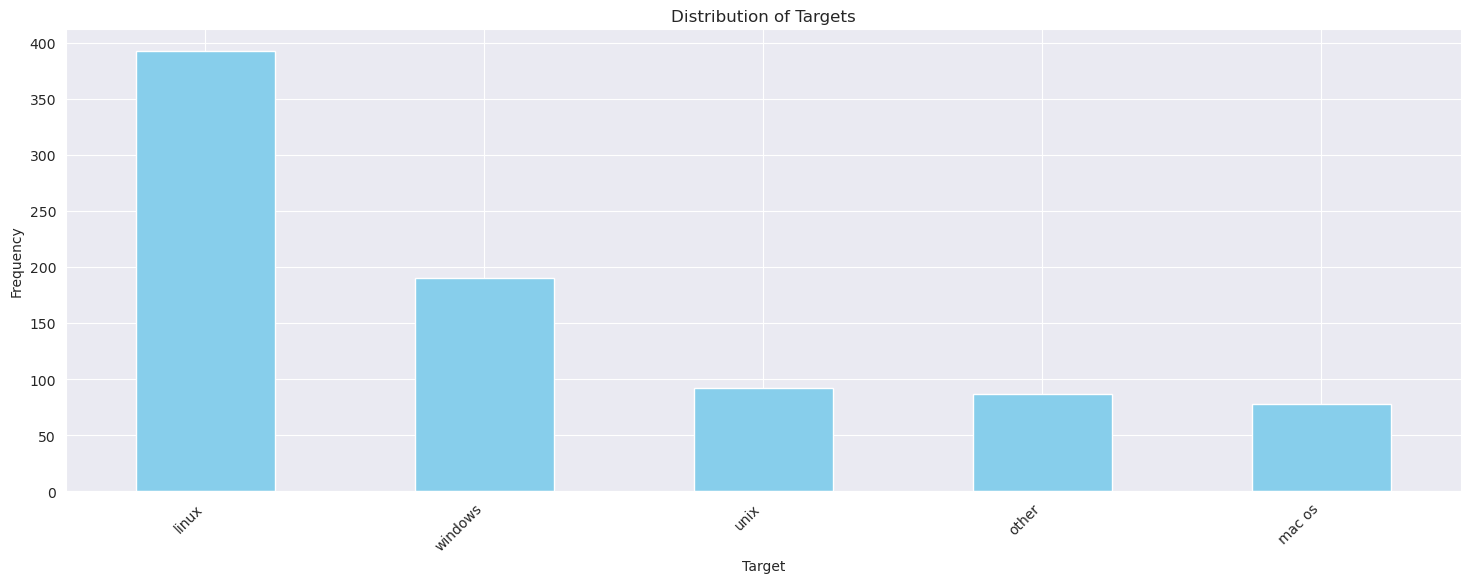

In [18]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('linux',): 324
('windows',): 183
('unix',): 92
('other',): 87
('mac os',): 67
('linux', 'unix'): 32
('linux', 'windows'): 27
('mac os', 'windows'): 11
('linux', 'mac os'): 7
('windows', 'unix'): 7
('linux', 'mac os', 'unix'): 2


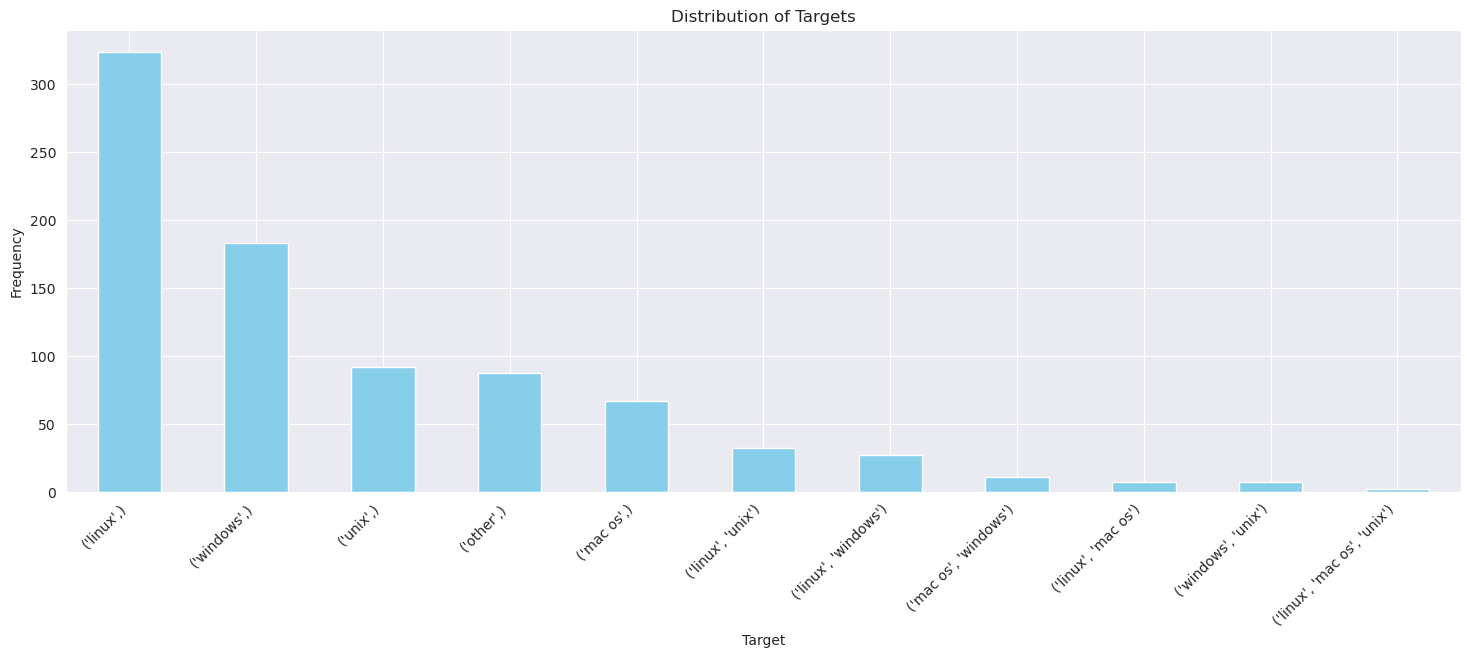

In [19]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [20]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 86


In [21]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'linux':
overflow         201
buffer           197
vulnerability    118
local             65
professional      51
slideshow         46
photo             43
discover          39
15                38
807               38
dtype: int64
Top 10 words for target 'windows':
vulnerability           164
window                  132
microsoft                81
contain                  43
zeroday                  35
docker                   34
elevationofprivilege     32
version                  28
service                  23
denial                   22
dtype: int64
Top 10 words for target 'mac os':
mac       38
app       33
apps      32
remove    32
user      32
leak      31
data      30
micro     30
store     30
trend     30
dtype: int64
Top 10 words for target 'unix':
vulnerability      63
function           39
imagemagick        36
service            36
denial             33
leak               22
memory             20
read               16
gnu                15
readonejn

## 5. Feature Engineering

In [22]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = threat_tweets[threat_tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('linux',): 324
('windows',): 183
('unix',): 92
('other',): 87
('mac os',): 67
('linux', 'unix'): 32
('linux', 'windows'): 27
('mac os', 'windows'): 11
('linux', 'mac os'): 7
('windows', 'unix'): 7


Preprocess the `text` column into embeddings

In [23]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(
            x=list_str,
            embedder_addr=model_path,
            preprocessing_list=[replace_text_components, clean_text]
        )

    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str


texts = filtered_df['text']
x = preprocess_texts(
    list_str=texts,
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None
)
#X = preprocess_texts(list_str=filtered_df['text'], model_path=GLOVE_6B_300D_TXT, embedding_dim=300)

Convert the `target` column into a binary multi-label matrix

In [24]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Perform pruning and subsampling of the dataset to remove infrequent targets

In [25]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=x,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

Create a dictionary that maps label indices to unique label sets

In [26]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

## 6. Model Training

In [27]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    x, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

print(
    f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 669 × 768      	y = 669 × 5        
Validation:    	X = 168 × 768      	y = 168 × 5        


In [30]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 748 × 768      	y = 748            
Validation:    	X = 187 × 768      	y = 187            


In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train_lp = smote.fit_resample(X_train, y_train_lp)
y_train = np.array(unique_label_sets[y_train_lp])
print(f"{X_train.shape}, {len(y_train_lp)}")
smote = SMOTE(random_state=42)
X_train_pst, y_train_pst = smote.fit_resample(X_train_pst, y_train_pst)
print(f"{X_train_pst.shape}, {len(y_train_pst)}")

(2256, 768), 2256


### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [32]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 3/3 [00:30<00:00, 10.02s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 3/3 [00:52<00:00, 17.49s/it]


#### 4.1.3. CC (Classifier Chains)


In [37]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [00:29<00:00,  9.83s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [38]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


#### 4.2.2. PSt (Pruned Sets)


In [39]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 3/3 [00:14<00:00,  4.75s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [40]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [00:28<00:00,  9.58s/it]


#### 4.3.2. MBR (Meta-Binary Relevance)


In [41]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [02:43<00:00, 54.51s/it]


## 7. Model Evaluation

In [42]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [43]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [44]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

              precision    recall  f1-score   support

       linux       0.93      0.84      0.88        77
      mac os       1.00      0.71      0.83        17
       other       1.00      0.89      0.94        18
        unix       0.95      0.69      0.80        26
     windows       0.93      0.87      0.90        45

   micro avg       0.94      0.82      0.88       183
   macro avg       0.96      0.80      0.87       183
weighted avg       0.94      0.82      0.88       183
 samples avg       0.82      0.82      0.82       183

Accuracy:	0.7917
AUC:	0.8912


#### 7.1.2. CLR (Calibrated Label Ranking)


In [45]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [46]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

              precision    recall  f1-score   support

       linux       0.91      0.82      0.86        77
      mac os       1.00      0.76      0.87        17
       other       1.00      0.89      0.94        18
        unix       0.91      0.77      0.83        26
     windows       0.89      0.87      0.88        45

   micro avg       0.92      0.83      0.87       183
   macro avg       0.94      0.82      0.88       183
weighted avg       0.92      0.83      0.87       183
 samples avg       0.81      0.83      0.82       183

Accuracy:	0.7857
AUC:	0.8987


#### 7.1.3. CC (Classifier Chains)


In [47]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [48]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

              precision    recall  f1-score   support

       linux       0.91      0.82      0.86        77
      mac os       1.00      0.76      0.87        17
       other       0.89      0.94      0.92        18
        unix       0.95      0.81      0.88        26
     windows       0.85      0.89      0.87        45

   micro avg       0.91      0.84      0.87       183
   macro avg       0.92      0.84      0.88       183
weighted avg       0.91      0.84      0.87       183
 samples avg       0.83      0.84      0.83       183

Accuracy:	0.7917
AUC:	0.9081


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [49]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [50]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

              precision    recall  f1-score   support

       linux       0.93      0.84      0.88        77
      mac os       0.92      0.71      0.80        17
       other       0.95      1.00      0.97        18
        unix       0.86      0.92      0.89        26
     windows       0.86      0.96      0.91        45

   micro avg       0.90      0.89      0.89       183
   macro avg       0.90      0.89      0.89       183
weighted avg       0.90      0.89      0.89       183
 samples avg       0.90      0.89      0.89       183

Accuracy:	0.8750
AUC:	0.9275


#### 7.2.2. PSt (Pruned Sets)


In [51]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [52]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

              precision    recall  f1-score   support

       linux       0.84      0.84      0.84        81
      mac os       0.67      0.76      0.71        21
       other       0.88      0.78      0.82        18
        unix       0.94      0.81      0.87        36
     windows       0.87      0.89      0.88        44

   micro avg       0.84      0.83      0.84       200
   macro avg       0.84      0.81      0.82       200
weighted avg       0.85      0.83      0.84       200
 samples avg       0.84      0.83      0.83       200

Accuracy:	0.8182
AUC:	0.8833


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [53]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [54]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

              precision    recall  f1-score   support

       linux       0.89      0.86      0.87        77
      mac os       0.93      0.82      0.88        17
       other       0.84      0.89      0.86        18
        unix       0.81      0.65      0.72        26
     windows       0.91      0.87      0.89        45

   micro avg       0.88      0.83      0.86       183
   macro avg       0.88      0.82      0.84       183
weighted avg       0.88      0.83      0.85       183
 samples avg       0.84      0.84      0.83       183

Accuracy:	0.7976
AUC:	0.8915


#### 7.3.2. MBR (Meta-Binary Relevance)


In [55]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [56]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

              precision    recall  f1-score   support

       linux       0.89      0.87      0.88        77
      mac os       0.93      0.82      0.88        17
       other       1.00      0.89      0.94        18
        unix       0.95      0.69      0.80        26
     windows       0.87      0.91      0.89        45

   micro avg       0.91      0.85      0.88       183
   macro avg       0.93      0.84      0.88       183
weighted avg       0.91      0.85      0.88       183
 samples avg       0.85      0.85      0.84       183

Accuracy:	0.7976
AUC:	0.9036


## 8. Summary


In [57]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.791667,xgb,OneVsRestClassifier(estimator=XGBClassifier(ba...,0.824405,0.821429,0.819444,0.05,0.943396,0.819672,0.877193,0.960902,0.79958,0.869934,1.839286,precision recall f1-score ...
CLR,0.785714,xgb,CalibratedLabelRankClassifier(classes=array(['...,0.8125,0.827381,0.816468,0.053571,0.920732,0.825137,0.870317,0.9417,0.821535,0.876119,1.815476,precision recall f1-score ...
CC,0.791667,xgb,"ChainOfClassifiers(classes=array(['linux', 'ma...",0.830357,0.842262,0.831349,0.053571,0.905882,0.84153,0.872521,0.922678,0.844783,0.878633,1.77381,precision recall f1-score ...
LP,0.875,random_forest,LabelPowersetClassifier(classifier=RandomFores...,0.895833,0.889881,0.890873,0.046429,0.9,0.885246,0.892562,0.903232,0.885734,0.890296,1.547619,precision recall f1-score ...
PST,0.818182,random_forest,LabelPowersetClassifier(classifier=RandomFores...,0.836898,0.831551,0.832442,0.069519,0.84264,0.83,0.836272,0.836665,0.814222,0.823245,1.759358,precision recall f1-score ...
CDN,0.785714,xgb,ConditionalDependencyNetwork(classifier=XGBCla...,0.803571,0.803571,0.801587,0.072619,0.854651,0.803279,0.828169,0.844865,0.800131,0.821373,1.886905,precision recall f1-score ...
MBR,0.797619,xgb,MetaBinaryRelevance(classifier=XGBClassifier(b...,0.845238,0.854167,0.844246,0.05119,0.906977,0.852459,0.878873,0.929275,0.837193,0.877812,1.744048,precision recall f1-score ...


In [53]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)

In [58]:
max_f1_score = 0.
optimal_model = None
for _, performance in performances.iterrows():
    if max_f1_score < performance['Macro F1']:
        max_f1_score = performance['Macro F1']
        optimal_model = performance['Model']

if OVERWRITE:
    joblib.dump(optimal_model, OPERATING_SYSTEMS_PKL, compress=9)

In [59]:
z = joblib.load(filename=OPERATING_SYSTEMS_PKL)
type(z)

utils.LabelPowersetClassifier